In [7]:
import seaborn as sns 
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [8]:
seed = 1245
test_size = 0.2
k_folds = 5

n_neighbors = 8
weights = 'distance'
algorithm = 'kd_tree'

In [9]:
data = loadmat('Salinas_corrected.mat')['salinas_corrected']
label = loadmat('Salinas_gt.mat')['salinas_gt']
data_reshaped = data.reshape(-1, data.shape[-1])
label_reshaped = label.flatten()
X_train, X_test, y_train, y_test = train_test_split(data_reshaped, label_reshaped, test_size=test_size, random_state=seed)

In [10]:
pipe = Pipeline([
    ('norm', MinMaxScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm))
    ])

In [11]:
# # Gird search to find the best hyperparameters
# parameters = [
#     {
#         'clf__algorithm': ['ball_tree', 'kd_tree'],
#         'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8],
#         'clf__weights': ['distance', 'uniform'],
#     }
# ]
# model = GridSearchCV(pipe, parameters, refit = True, cv = 5, verbose = 1, n_jobs = -1)
# model.fit(X_train, y_train)
# print('Best hyperparameters: ', model.best_params_)
# print('Best performance: : ', model.best_score_)

# max_depth = model.best_params_['clf__max_depth']
# n_estimators = model.best_params_['clf__n_estimators']

In [12]:
# KFold
y_preds = []
label_preds = []
pred_test_scores = []

kfolds = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

for k, (train_index, test_index) in enumerate(kfolds.split(X_train)):
    X_train_fold, y_train_fold = X_train[train_index], y_train[train_index]
    X_test_fold, y_test_fold = X_train[test_index], y_train[test_index]
    pipe.fit(X_train_fold, y_train_fold)

    y_pred = pipe.predict(X_test)
    y_pred_fold = pipe.predict(X_test_fold)
    label_pred = pipe.predict(data_reshaped)

    pred_test_score = accuracy_score(y_test, y_pred)
    pred_valid_score = accuracy_score(y_test_fold, y_pred_fold)

    y_preds.append(y_pred)
    label_preds.append(label_pred)
    pred_test_scores.append(pred_test_score)
    
    print("Fold ", k, "Test set: ", round(pred_test_score, 4), "Validation Set: ", round(pred_valid_score, 4))

Fold  0 Test set:  0.9062 Validation Set:  0.907
Fold  1 Test set:  0.9062 Validation Set:  0.9072
Fold  2 Test set:  0.906 Validation Set:  0.9008
Fold  3 Test set:  0.9067 Validation Set:  0.9027
Fold  4 Test set:  0.8999 Validation Set:  0.9042


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     11327
           1       0.87      0.95      0.91       419
           2       0.89      0.98      0.93       720
           3       0.83      0.83      0.83       394
           4       0.90      0.89      0.89       288
           5       0.87      0.96      0.92       529
           6       0.90      0.97      0.93       781
           7       0.93      0.98      0.96       730
           8       0.79      0.84      0.82      2264
           9       0.89      0.95      0.92      1260
          10       0.88      0.89      0.88       675
          11       0.83      0.88      0.85       211
          12       0.87      0.93      0.90       384
          13       0.85      0.85      0.85       212
          14       0.81      0.81      0.81       200
          15       0.75      0.71      0.73      1454
          16       0.90      0.96      0.93       373

    accuracy              

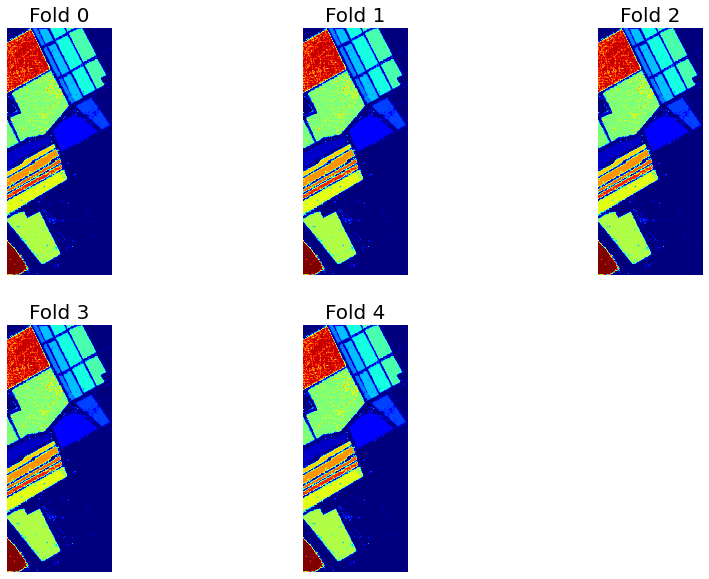

In [14]:
fig = plt.figure(figsize=(15, 10))
for k in range(k_folds):
    ax = plt.subplot(2, 3, k + 1)
    ax.set_title(f"Fold {k}", fontsize=20)
    plt.axis('off')
    plt.imshow(label_preds[0].reshape(label.shape[0], label.shape[1]), cmap='jet')

<AxesSubplot:>

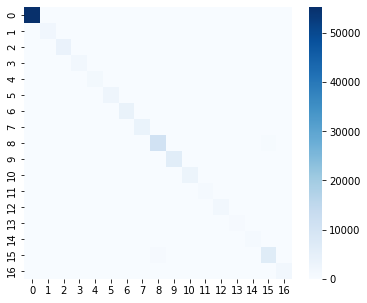

In [15]:
best_fold = pred_test_scores.index(max(pred_test_scores))
fig = plt.figure(figsize=(6, 5))
cm = confusion_matrix(label_reshaped, label_preds[best_fold])
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")